In [1]:
import torch
import os
import mlflow
import numpy as np
import matplotlib as mpl
from ultralytics import YOLO
import ultralytics
import pycocotools.coco
import pycocowriter.coco2yolo
import requests
import sys
from hierarchical_yolo.hierarchical_detection import *
from hierarchical_yolo.deep7_model import *
import hierarchical_yolo.utils

In [2]:
'''
deep7 categories:

  0: Kalekale
  1: Opakapaka
  2: "Hapu\u02BBupu\u02BBu"
  3: Gindai
  4: Other or Can't Tell
  5: Ehu
  6: Lehi
  7: Onaga
  8: Snapper
  9: Grouper
  10: Object
'''

deep7_hierarchy = {
    0: 8,
    1: 8,
    2: 9,
    3: 8,
    5: 8,
    6: 8,
    7: 8,
    4: 10,
    8: 10,
    9: 10
}

In [3]:
from ultralytics import settings

# View all settings
print(settings)

JSONDict("/home/noaa_brown/.config/Ultralytics/settings.json"):
{
  "settings_version": "0.0.6",
  "datasets_dir": "/home/noaa_brown/datasets",
  "weights_dir": "/home/noaa_brown/hierarchical_yolo/weights",
  "runs_dir": "/home/noaa_brown/hierarchical_yolo/runs",
  "uuid": "2768c477e7938b5779aff75aed83103f60cf5680dbe7372dfa0b27c233b7d105",
  "sync": true,
  "api_key": "",
  "openai_api_key": "",
  "clearml": true,
  "comet": true,
  "dvc": true,
  "hub": true,
  "mlflow": true,
  "neptune": true,
  "raytune": true,
  "tensorboard": false,
  "wandb": false,
  "vscode_msg": true
}


In [4]:
devices = list(range(torch.cuda.device_count()))
for i in devices:
    print(torch.cuda.get_device_properties(i).name)

NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti
NVIDIA GeForce GTX 1080 Ti


In [5]:
DATA = '../data'
UPLOAD_URL = 'https://storage.googleapis.com/nmfs_odp_hq/nodd_tools/datasets/oceaneyes/category_balanced_sample/annotations.json'
DOWNLOAD_PATH = os.path.join(DATA, 'download')
COCO_PATH = os.path.join(DOWNLOAD_PATH, 'annotations.json')
YOLO_PATH = os.path.join(DOWNLOAD_PATH, 'yolo_training_data')
IMAGES_PATH = os.path.join(YOLO_PATH, 'annotations', 'images')
os.makedirs(YOLO_PATH, exist_ok=True)
os.makedirs(DOWNLOAD_PATH, exist_ok=True)

In [6]:
uploaded_coco_file = requests.get(UPLOAD_URL)
with open(COCO_PATH, 'wb') as f:
    f.write(uploaded_coco_file.content)
    coco = pycocotools.coco.COCO(COCO_PATH)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


In [7]:
def coco_category_dist(coco):
    import matplotlib.pyplot as plt
    cats, cnt = np.unique(list(map(lambda x: x['category_id'], coco.anns.values())), return_counts=True)
    cat_names = list(map(lambda cat_id: coco.cats[cat_id]['name'], cats))
    plt.bar(cat_names, cnt)
    for i, value in enumerate(cnt):
        plt.text(i, value + 0.5, str(value), ha='center', va='bottom')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    return plt

<module 'matplotlib.pyplot' from '/home/noaa_brown/hierarchical_yolo/.venv/lib/python3.12/site-packages/matplotlib/pyplot.py'>

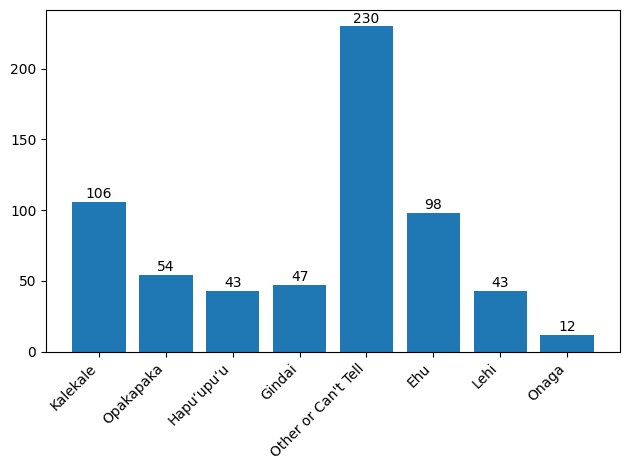

In [8]:
coco_category_dist(coco)

In [9]:
coco.info()

year: 2024
version: 0.1
description: https://www.zooniverse.org/projects/benjamin-dot-richards/oceaneyes/about/research
contributor: None
url: None
date_created: 2025-02-06T20:56:54.886937+00:00


In [10]:
pycocowriter.coco2yolo.coco2yolo(DOWNLOAD_PATH, YOLO_PATH)

Annotations /home/noaa_brown/hierarchical_yolo/data/download/annotations.json: 100%|██████████| 200/200 [00:00<00:00, 4476.55it/s]

COCO data converted successfully.
Results saved to /home/noaa_brown/hierarchical_yolo/notebooks/coco_converted
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
downloaded 0/200 images (t=0.0s)
downloaded 1/200 images (t=0.0s)
downloaded 2/200 images (t=0.0s)
downloaded 3/200 images (t=0.0s)
downloaded 4/200 images (t=0.0s)
downloaded 5/200 images (t=0.0s)
downloaded 6/200 images (t=0.0s)
downloaded 7/200 images (t=0.0s)
downloaded 8/200 images (t=0.0s)
downloaded 9/200 images (t=0.0s)
downloaded 10/200 images (t=0.0s)
downloaded 11/200 images (t=0.0s)
downloaded 12/200 images (t=0.0s)
downloaded 13/200 images (t=0.0s)
downloaded 14/200 images (t=0.0s)
downloaded 15/200 images (t=0.0s)
downloaded 16/200 images (t=0.0s)
downloaded 17/200 images (t=0.0s)
downloaded 18/200 images (t=0.0s)
downloaded 19/200 images (t=0.0s)
downloaded 20/200 images (t=0.0s)
downloaded 21/200 i

In [11]:
# TODO: the yolov8.yaml model file downloaded from Ultralytics needs manual editing for the number of classes
YOLO_YAML = os.path.join(DATA, 'yolov8.yaml')
YOLO_BASE_MODEL = os.path.join(DATA, 'yolov8n.pt')
YOLO_TRAIN_YAML = os.path.join(YOLO_PATH, 'train.yaml')

In [12]:
mlflow.autolog()

In [13]:
model = YOLO(YOLO_YAML).load(YOLO_BASE_MODEL)  # build a new model from scratch

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 319/355 items from pretrained weights


In [14]:
RETRAIN=True

In [15]:
if RETRAIN:
    results = model.train(
        data=YOLO_TRAIN_YAML, 
        epochs=100, imgsz=640, 
        device=devices, 
        batch=max(len(devices), 1),
        trainer=Deep7HierarchicalDetectionTrainer
    )

New https://pypi.org/project/ultralytics/8.3.186 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.119 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:2 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:3 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:4 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:5 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:6 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
engine/trainer: task=detect, mode=train, model=../data/yolov8.yaml, data=../data/download/yolo_training_data/train.yaml, epochs=100, time=None, patience=100, batch=7, imgsz=640, save=True, sav

train: Scanning /home/noaa_brown/hierarchical_yolo/data/download/yolo_training_data/annotations/labels.cache... 200 images, 1 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1197.1±726.1 MB/s, size: 92.7 KB)


val: Scanning /home/noaa_brown/hierarchical_yolo/data/download/yolo_training_data/annotations/labels.cache... 200 images, 1 backgrounds, 0 corrupt: 100%|██████████| 200/200 [00:00<?, ?it/s]


Plotting labels to /home/noaa_brown/hierarchical_yolo/runs/detect/train125/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000833, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0004921875), 63 bias(decay=0.0)
MLflow: logging run_id(276d4b66f5194aa8849bbb4c6b5254c9) to /home/noaa_brown/hierarchical_yolo/runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri /home/noaa_brown/hierarchical_yolo/runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
Image sizes 640 train, 640 val
Using 14 dataloader workers
Logging results to /home/noaa_brown/hierarchical_yolo/runs/detect/train125
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      0.26G      2.343      111.8      1.589          2        640: 100%|██████████| 29/29 [00:08<00:00,  3.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:17<00:00,  5.84it/s]


                   all        200        611   0.000365     0.0195   0.000308   7.84e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100     0.283G      1.963      92.14      1.343         14        640: 100%|██████████| 29/29 [00:06<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:17<00:00,  5.88it/s]


                   all        200        611   0.000168     0.0154   0.000122   5.58e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100     0.297G      2.325      74.17      1.416          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


                   all        200        611      0.125     0.0115   2.49e-05    8.2e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100     0.385G      2.269      86.14       1.13          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:21<00:00,  4.75it/s]


                   all        200        611   7.67e-05     0.0184   4.65e-05   1.57e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100     0.389G      2.798      60.47      1.706         27        640: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


                   all        200        611      0.125    0.00926    4.4e-05   6.46e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100     0.389G      2.923      52.71      1.734          5        640: 100%|██████████| 29/29 [00:06<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


                   all        200        611   3.19e-05    0.00999   1.66e-05   5.02e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100     0.402G      2.701      46.79      1.656          3        640: 100%|██████████| 29/29 [00:06<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


                   all        200        611      0.376     0.0061   6.96e-05   1.93e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100     0.402G      1.919      54.52      1.056          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


                   all        200        611   0.000106    0.00768   2.36e-05   1.09e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100     0.404G      2.574      34.91      1.498          3        640: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.09it/s]


                   all        200        611   9.25e-05    0.00463   2.98e-05   9.65e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100     0.404G       2.43       34.2      1.251          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.26it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


                   all        200        611   4.47e-05    0.00231   1.59e-05    1.1e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      0.42G      2.067       31.8      1.054          7        640: 100%|██████████| 29/29 [00:06<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.08it/s]


                   all        200        611   0.000134    0.00694   5.24e-05   9.58e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      0.42G      2.248      22.18      1.355          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


                   all        200        611   4.97e-05    0.00463   2.61e-05    7.7e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      0.42G      2.445      22.51      1.351          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


                   all        200        611      0.125    0.00536   6.23e-05   6.23e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      0.42G      2.151      21.53      1.248          3        640: 100%|██████████| 29/29 [00:06<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.07it/s]


                   all        200        611      0.125    0.00536   7.87e-05   1.22e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      0.42G      2.412      16.87      1.499          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


                   all        200        611   1.25e-05    0.00305   8.09e-06   4.85e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100     0.438G      2.807      15.45      1.636          4        640: 100%|██████████| 29/29 [00:06<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


                   all        200        611      0.125    0.00305    0.00012   1.35e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100     0.438G      2.261      18.82      1.355          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


                   all        200        611       0.25    0.00463   4.94e-05   4.94e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100     0.438G      2.511      10.93      1.469          9        640: 100%|██████████| 29/29 [00:06<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


                   all        200        611       0.25    0.00231   2.73e-05   2.73e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100     0.438G      1.792      14.77      1.046         15        640: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.05it/s]


                   all        200        611      0.125    0.00841   7.95e-05   3.63e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100     0.455G      2.305      10.46      1.422          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


                   all        200        611      0.125    0.00305   4.33e-05   2.43e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100     0.471G      2.432      7.028      1.504          0        640: 100%|██████████| 29/29 [00:07<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


                   all        200        611      0.125    0.00536   5.47e-05   2.17e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100     0.471G      2.685      7.455       1.43          5        640: 100%|██████████| 29/29 [00:06<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


                   all        200        611      0.125    0.00536    0.00011   2.44e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100     0.471G      2.213      7.496       1.18          2        640: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.03it/s]


                   all        200        611   0.000307      0.011   0.000169   4.07e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100     0.471G      2.508       7.76      1.223          6        640: 100%|██████████| 29/29 [00:06<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.02it/s]


                   all        200        611      0.125    0.00536    5.2e-05   1.36e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100     0.471G      1.923      7.777      1.096          0        640: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


                   all        200        611   7.49e-05     0.0244    4.8e-05   1.37e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100     0.471G       2.22      6.745      1.222          2        640: 100%|██████████| 29/29 [00:06<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:19<00:00,  5.00it/s]


                   all        200        611   0.000118     0.0194   6.25e-05   1.29e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100     0.471G      2.347       7.55      1.042          0        640: 100%|██████████| 29/29 [00:06<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


                   all        200        611      0.125    0.00694   6.93e-05   1.14e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100     0.471G      2.236      5.797      1.387          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


                   all        200        611       0.25    0.00231   2.99e-05   6.65e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100     0.471G      2.003      5.458     0.9797         11        640: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


                   all        200        611   0.000106    0.00768   5.46e-05   8.58e-06

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100     0.471G      2.484      4.995      1.294          7        640: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


                   all        200        611   0.000732     0.0197    0.00105   0.000335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100     0.471G       2.59      4.841      1.417          2        640: 100%|██████████| 29/29 [00:07<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


                   all        200        611   0.000823     0.0317   0.000646    0.00022

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100     0.471G      1.963      4.158      1.044          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


                   all        200        611    0.00235     0.0494    0.00139   0.000367

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100     0.471G      2.608      4.629      1.222          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


                   all        200        611    0.00233     0.0335    0.00133   0.000356

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100     0.471G       2.02      3.759      1.028          4        640: 100%|██████████| 29/29 [00:06<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


                   all        200        611      0.502    0.00463   0.000716   0.000164

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100     0.471G      1.993       3.21      1.132          3        640: 100%|██████████| 29/29 [00:06<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


                   all        200        611       0.25    0.00841   6.36e-05   2.43e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100     0.475G      1.487      3.479      0.818          6        640: 100%|██████████| 29/29 [00:06<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


                   all        200        611      0.125     0.0168   7.11e-05   2.85e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100     0.488G      1.952      4.334      0.886          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


                   all        200        611       0.25     0.0061   8.52e-05   3.27e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100     0.488G      1.869      2.635      1.116          4        640: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


                   all        200        611       0.25     0.0107   0.000112   2.42e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100     0.488G      1.977      2.512      1.385          2        640: 100%|██████████| 29/29 [00:07<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


                   all        200        611       0.25     0.0177   0.000145   4.78e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100     0.488G      2.228      2.933      1.203          1        640: 100%|██████████| 29/29 [00:07<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


                   all        200        611       0.25     0.0177   0.000152   5.16e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100     0.488G      2.015      2.644      1.159          6        640: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


                   all        200        611    0.00178     0.0311    0.00108   0.000207

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100     0.488G      1.846       2.48      1.106          8        640: 100%|██████████| 29/29 [00:06<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


                   all        200        611    0.00142     0.0203   0.000896   0.000188

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100     0.488G      2.165      2.957      1.106          4        640: 100%|██████████| 29/29 [00:06<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


                   all        200        611   0.000861      0.038   0.000457   0.000167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100     0.488G      2.455      3.028      1.404          0        640: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  5.00it/s]


                   all        200        611    0.00177     0.0245   0.000932   0.000144

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100     0.488G      2.674      2.694      1.422          2        640: 100%|██████████| 29/29 [00:07<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


                   all        200        611    0.00239     0.0315    0.00128    0.00035

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100     0.488G      2.146       2.62      1.093          2        640: 100%|██████████| 29/29 [00:06<00:00,  4.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


                   all        200        611   0.000632     0.0199   0.000328   0.000136

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100     0.488G      1.716      2.094      1.109          0        640: 100%|██████████| 29/29 [00:06<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


                   all        200        611   0.000455     0.0255   0.000243   7.51e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100     0.488G      2.127      2.217       1.02          6        640: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.99it/s]


                   all        200        611    0.00159     0.0288    0.00085   0.000134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100     0.488G      2.101      2.692      1.032          0        640: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


                   all        200        611    0.00105      0.025   0.000565   0.000122

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100     0.488G      1.867      2.245      1.052          4        640: 100%|██████████| 29/29 [00:06<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


                   all        200        611    0.00286     0.0313    0.00155    0.00049

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100     0.488G       2.05      2.024      1.082          3        640: 100%|██████████| 29/29 [00:06<00:00,  4.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


                   all        200        611    0.00181      0.027    0.00101   0.000305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100     0.488G      1.997      2.237      1.186          2        640: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


                   all        200        611    0.00182     0.0197    0.00101   0.000279

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100     0.488G      1.943      1.933      1.208          0        640: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


                   all        200        611    0.00377     0.0254    0.00195   0.000841

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100     0.488G      1.468      1.888     0.8592          4        640: 100%|██████████| 29/29 [00:06<00:00,  4.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


                   all        200        611    0.00246     0.0292    0.00128   0.000498

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100     0.488G      2.313       2.09      1.305          6        640: 100%|██████████| 29/29 [00:06<00:00,  4.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


                   all        200        611    0.00154     0.0256   0.000788   0.000244

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100     0.488G      1.792      1.825      1.131          3        640: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


                   all        200        611      0.125     0.0123   0.000101   3.34e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100     0.488G      2.031      2.094      1.239          4        640: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


                   all        200        611    0.00195     0.0246    0.00101   0.000305

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100     0.488G      1.628      1.877     0.8583          8        640: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


                   all        200        611    0.00113     0.0403   0.000608   0.000218

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100     0.488G      1.749      1.717      1.097          0        640: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


                   all        200        611     0.0022     0.0335    0.00121   0.000309

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100     0.488G      1.727      1.817      1.206          2        640: 100%|██████████| 29/29 [00:06<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


                   all        200        611    0.00589     0.0276    0.00327    0.00127

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100     0.488G      1.855      2.047      1.109          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


                   all        200        611    0.00417      0.031    0.00228   0.000977

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100     0.488G      1.959      1.894      1.239          3        640: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


                   all        200        611    0.00383     0.0338    0.00201   0.000614

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100     0.488G       2.01      2.009      1.217          0        640: 100%|██████████| 29/29 [00:06<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


                   all        200        611    0.00155     0.0379   0.000808   0.000134

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100     0.488G      1.622       1.87     0.9301          6        640: 100%|██████████| 29/29 [00:06<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


                   all        200        611    0.00175     0.0256   0.000907   0.000281

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100     0.488G      1.868      1.867      1.105          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


                   all        200        611    0.00383     0.0366    0.00204   0.000607

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100     0.488G      2.043      1.942      1.311          4        640: 100%|██████████| 29/29 [00:06<00:00,  4.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


                   all        200        611    0.00415     0.0336    0.00222   0.000801

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100     0.488G      1.757      1.689      1.158          2        640: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


                   all        200        611    0.00386       0.03    0.00204   0.000615

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100     0.488G      1.875       1.82      1.177          2        640: 100%|██████████| 29/29 [00:06<00:00,  4.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


                   all        200        611    0.00261     0.0384    0.00139   0.000485

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100     0.488G      1.753      1.847     0.9057         11        640: 100%|██████████| 29/29 [00:06<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


                   all        200        611   0.000892     0.0262   0.000466    0.00019

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100     0.488G      1.685      1.749      1.234          9        640: 100%|██████████| 29/29 [00:06<00:00,  4.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


                   all        200        611      0.125       0.02   0.000154   3.67e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100     0.488G      2.299      1.928      1.276         14        640: 100%|██████████| 29/29 [00:07<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


                   all        200        611   0.000416     0.0264   0.000218   2.83e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100     0.488G      1.776      1.651     0.9599          9        640: 100%|██████████| 29/29 [00:06<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


                   all        200        611   0.000308     0.0384   0.000164   4.84e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100     0.488G      1.629      1.817     0.8858         12        640: 100%|██████████| 29/29 [00:06<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.89it/s]


                   all        200        611   0.000404     0.0467   0.000218   5.92e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      0.49G      1.533      1.523       1.14          0        640: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.86it/s]


                   all        200        611   0.000235     0.0483   0.000133   4.45e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      0.49G      1.695      1.414      1.151          0        640: 100%|██████████| 29/29 [00:06<00:00,  4.28it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


                   all        200        611    0.00118     0.0456   0.000622   0.000167

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      0.49G      1.799        1.6     0.9071          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.25it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


                   all        200        611    0.00208     0.0339    0.00109     0.0003

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      0.49G      1.778      1.549      1.028          4        640: 100%|██████████| 29/29 [00:06<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


                   all        200        611    0.00481     0.0335    0.00253   0.000593

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      0.49G      1.665      1.782      1.005          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


                   all        200        611    0.00305     0.0238    0.00161   0.000401

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      0.49G       1.74      1.728      1.115          0        640: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.97it/s]


                   all        200        611    0.00347      0.022    0.00183   0.000557

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      0.49G      1.686      1.469      0.877          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


                   all        200        611    0.00251     0.0231    0.00132   0.000519

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      0.49G      1.635      1.809     0.8795          2        640: 100%|██████████| 29/29 [00:06<00:00,  4.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.96it/s]


                   all        200        611    0.00155     0.0247   0.000813   0.000325

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      0.49G      2.019      1.625       1.15          0        640: 100%|██████████| 29/29 [00:07<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


                   all        200        611    0.00212     0.0231    0.00121   0.000438

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      0.49G      1.943      1.886      0.978          3        640: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


                   all        200        611      0.251    0.00536     0.0007   0.000313

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      0.49G      1.509      1.595     0.7989          4        640: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


                   all        200        611   0.000953     0.0226   0.000511    0.00024

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      0.49G      2.002      1.637      1.016          0        640: 100%|██████████| 29/29 [00:06<00:00,  4.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


                   all        200        611    0.00285     0.0318     0.0015   0.000381

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      0.49G       1.65      1.585     0.9602          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


                   all        200        611    0.00128     0.0323   0.000667   0.000257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      0.49G      2.198      1.903     0.9101          7        640: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


                   all        200        611    0.00121     0.0292   0.000635   0.000249

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      0.49G      1.613      1.508      1.071          0        640: 100%|██████████| 29/29 [00:06<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


                   all        200        611    0.00146     0.0292   0.000763   0.000296

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      0.49G      1.585      1.521      0.954          4        640: 100%|██████████| 29/29 [00:07<00:00,  4.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


                   all        200        611   0.000895     0.0242   0.000473   0.000235

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      0.49G      1.675      1.531      1.173          4        640: 100%|██████████| 29/29 [00:07<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


                   all        200        611    0.00089     0.0182   0.000471   0.000238
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      0.49G      1.484       1.49     0.7385          0        640: 100%|██████████| 29/29 [00:06<00:00,  4.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


                   all        200        611   0.000744     0.0182   0.000394   0.000202

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      0.49G      1.423      1.459     0.7829          0        640: 100%|██████████| 29/29 [00:06<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


                   all        200        611   0.000695     0.0182    0.00037   0.000182

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      0.49G      1.426      1.507     0.8512          8        640: 100%|██████████| 29/29 [00:06<00:00,  4.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


                   all        200        611    0.00076     0.0213   0.000401   0.000212

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      0.49G       1.59      1.638     0.9471          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


                   all        200        611      0.128      0.025   0.000702   0.000211

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      0.49G      1.524      1.545      0.826          2        640: 100%|██████████| 29/29 [00:06<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.92it/s]


                   all        200        611   0.000736     0.0236   0.000393   0.000172

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      0.49G      1.635       1.54     0.9389          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


                   all        200        611   0.000294       0.02    0.00016   8.45e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      0.49G       1.82      1.372      1.037         10        640: 100%|██████████| 29/29 [00:06<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


                   all        200        611       0.25     0.0146   0.000134   7.07e-05

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      0.49G      1.317      1.532     0.8493          1        640: 100%|██████████| 29/29 [00:06<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


                   all        200        611     0.0021     0.0189   0.000721   0.000277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      0.49G      1.549      1.545     0.8833          9        640: 100%|██████████| 29/29 [00:06<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


                   all        200        611    0.00208     0.0213   0.000753   0.000422

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      0.49G      1.665      1.525     0.8903          2        640: 100%|██████████| 29/29 [00:06<00:00,  4.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:20<00:00,  4.93it/s]


                   all        200        611    0.00233     0.0213   0.000819    0.00039

100 epochs completed in 0.759 hours.
Optimizer stripped from /home/noaa_brown/hierarchical_yolo/runs/detect/train125/weights/last.pt, 6.2MB
Optimizer stripped from /home/noaa_brown/hierarchical_yolo/runs/detect/train125/weights/best.pt, 6.2MB

Validating /home/noaa_brown/hierarchical_yolo/runs/detect/train125/weights/best.pt...
Ultralytics 8.3.119 🚀 Python-3.12.3 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:1 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:2 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:3 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:4 (NVIDIA GeForce GTX 1080 Ti, 11165MiB)
                                                       CUDA:5 (NVIDIA GeForc

                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 100/100 [00:13<00:00,  7.19it/s]


                   all        200        611    0.00582     0.0276    0.00324    0.00125
              Kalekale         17        101          0          0          0          0
             Opakapaka         21         54   0.000919     0.0556   0.000505   0.000149
            Hapuʻupuʻu         38         41   5.89e-05     0.0244   3.85e-05   1.31e-05
                Gindai         10         46          0          0          0          0
   Other or Can't Tell         66        216          0          0          0          0
                   Ehu         25         98     0.0455     0.0714     0.0253    0.00987
                  Lehi         13         43   8.92e-05     0.0698   4.78e-05   9.41e-06
                 Onaga          9         12          0          0          0          0
Speed: 3.9ms preprocess, 7.9ms inference, 0.0ms loss, 30.2ms postprocess per image
Results saved to /home/noaa_brown/hierarchical_yolo/runs/detect/train125
MLflow: results logged to /home/noaa_brown/

In [16]:
MODEL_LOCATION = os.path.join('..','runs','detect')
trained_models = os.listdir(os.path.join('..','runs','detect'))
model_numbers = map(lambda x: int(x[len('train'):]) if len(x) > len('train') else 0, trained_models)
latest_model = 'train' + str(max(model_numbers))

In [17]:
trained_model = YOLO(
    YOLO_YAML
).load(os.path.join(MODEL_LOCATION, latest_model, 'weights', 'best.pt')).to('cuda')
trained_model.eval()

WARNING ⚠️ no model scale passed. Assuming scale='n'.
Transferred 355/355 items from pretrained weights


YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_s

In [18]:
trained_model.overrides.get('imgsz', None)

In [26]:
random_img = os.path.join(IMAGES_PATH, str(np.random.choice(os.listdir(IMAGES_PATH))))
random_img

'../data/download/yolo_training_data/annotations/images/20190926_194111_20190926.200434.274.016255.jpg'

In [27]:
predictions = trained_model.predict(random_img, verbose=False, device=devices[:1], stream=True)
prediction = next(predictions)
prediction.boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 1., 1., 1., 3., 1., 1., 1., 3., 2., 1., 1., 1., 3., 3., 1., 3., 2., 2., 3., 2., 6., 2., 2., 1., 3., 2., 2., 2., 2., 2., 2., 3., 3., 2., 2., 2., 2., 3., 2., 3., 2., 2., 2., 6., 2., 6., 2., 6., 2., 6., 6., 1., 6., 6., 2., 2., 2., 2., 6., 6., 6., 2., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6., 6.,
        6., 6., 6., 6., 6., 6., 6., 6., 3., 6., 2., 6., 6.], device='cuda:0')
conf: tensor([0.7403, 0.6281, 0.5995, 0.5881, 0.5879, 0.5723, 0.5284, 0.5073, 0.5033, 0.4946, 0.4880, 0.4832, 0.4590, 0.4371, 0.4335, 0.4286, 0.4263, 0.4009, 0.3784, 0.3658, 0.3642, 0.3518, 0.3486, 0.3442, 0.3415, 0.3375, 0.3325, 0.3313, 0.3301, 0.3275, 0.3243, 0.3184, 0.3175, 0.3149, 0.3114, 0.3038, 0.3008, 0.2972, 0.2928,
        0.2924, 0.2899, 0.2893, 0.2886, 0.2857, 0.2854, 0.2849, 0.2754, 0.2732, 0.2729, 0.2716, 0.2708, 0.2692, 0.2683, 0.2671, 0.2669, 0.2648, 0.2645, 0.2643, 0.2628, 0.2595, 0.2578, 0.2569, 0.2569, 0.2567, 0.256

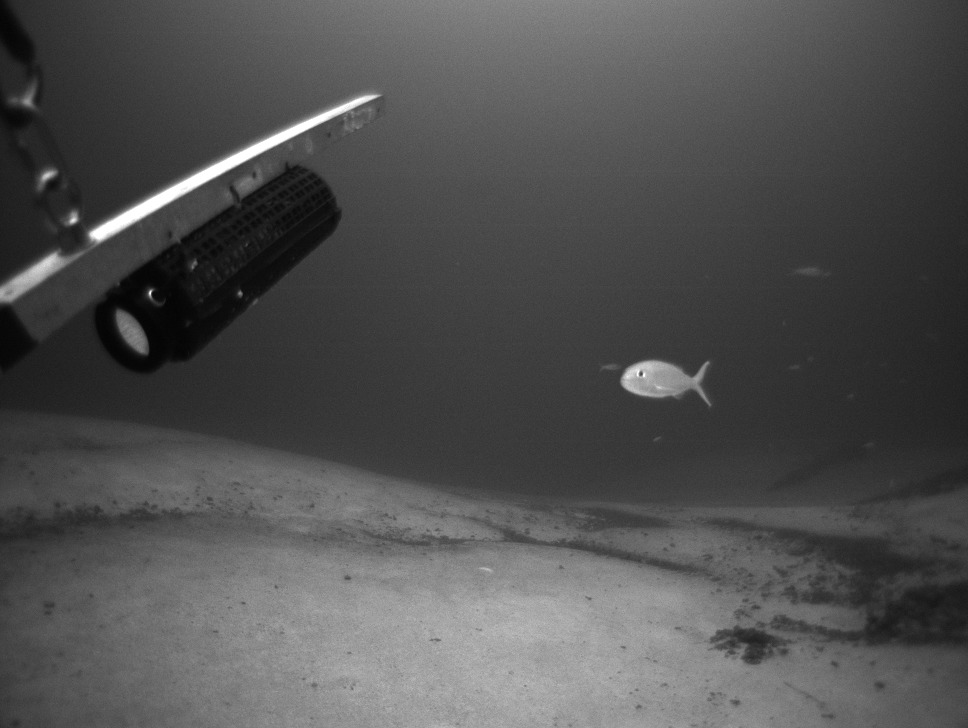

In [28]:
import torch
from PIL import Image

# Load and preprocess
image = Image.open(random_img).convert('RGB')
image

In [29]:
trained_model.model

DetectionModel(
  (model): Sequential(
    (0): Conv(
      (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (1): Conv(
      (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (act): SiLU(inplace=True)
    )
    (2): C2f(
      (cv1): Conv(
        (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (cv2): Conv(
        (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1))
        (act): SiLU(inplace=True)
      )
      (m): ModuleList(
        (0): Bottleneck(
          (cv1): Conv(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
          (cv2): Conv(
            (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (act): SiLU(inplace=True)
          )
        )
      )
    )
    (3): Conv(
      (conv): Conv2d(32

In [30]:
Deep7HierarchicalDetectionTrainer._hierarchy

{0: 4, 1: 4, 2: 4, 3: 4, 5: 4, 6: 4, 7: 4}

In [31]:
predicted_boxes, predicted_paths, predicted_path_scores = hierarchical_yolo.utils.hierarchical_predict(trained_model, Deep7HierarchicalDetectionTrainer._hierarchy, [image, image], cuda=True)

torch.Size([2, 12, 8400])
tensor([[1.6203e+02, 2.6759e+00, 3.9165e+01, 9.7894e+00, 4.0693e-05, 4.4310e-06, 4.4276e-05, 9.9093e-05, 9.8784e-05, 2.1937e-05, 3.9957e-02, 8.7031e-06],
        [1.6203e+02, 2.6759e+00, 3.9165e+01, 9.7894e+00, 4.0693e-05, 4.4310e-06, 4.4276e-05, 9.9093e-05, 9.8784e-05, 2.1937e-05, 3.9957e-02, 8.7031e-06]], device='cuda:0')
tensor([], device='cuda:0', size=(0, 1))
pickle
torch.Size([12, 0])
tensor([], device='cuda:0', size=(0, 1))
pickle
torch.Size([12, 0])
torch.Size([4, 0])
torch.Size([8, 0])
torch.Size([8, 0])


RuntimeError: The size of tensor a (0) must match the size of tensor b (8) at non-singleton dimension 2

In [ ]:
predicted_paths[0]

In [ ]:
predicted_path_scores[0]

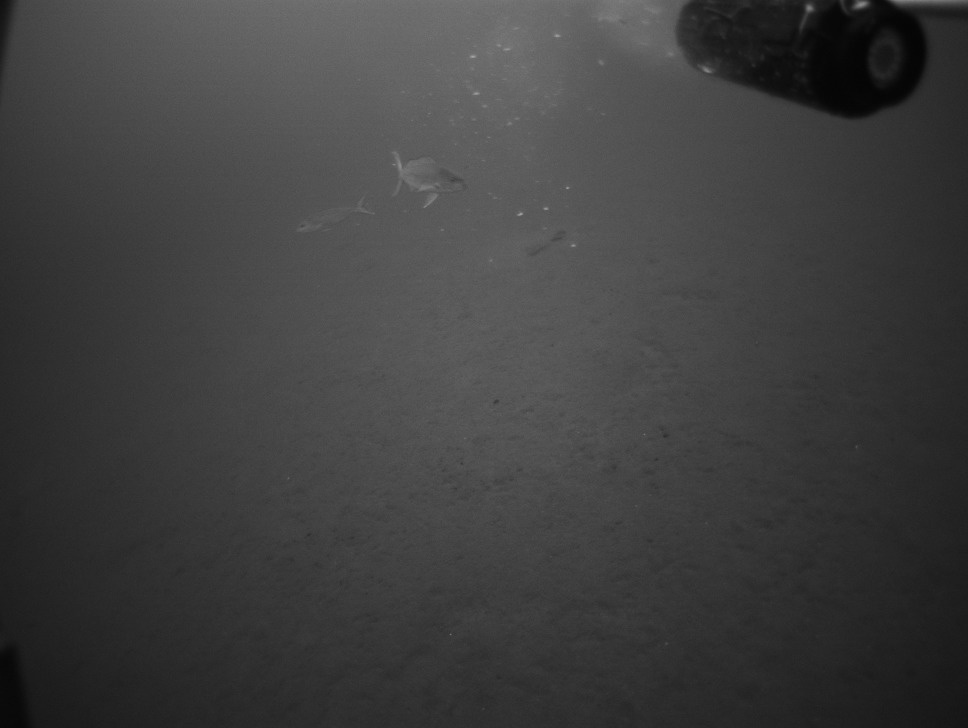

In [33]:
prediction.save('pickles.jpg')
from IPython.display import Image
Image(filename='pickles.jpg') 